In [5]:
import numpy as np

import os
import time
import pickle

import scipy.integrate as integrate
from scipy.optimize import minimize, root_scalar
from scipy.stats import skew


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")


from SALib.analyze import pawn
from SALib.sample import latin

### Constants

In [2]:
gamma  = 2.1 # utility function parameter
A      = 1.2 # utility function parameter
r0     = 0.5 # left bound for uniform random return on project
r1     = 2.5 # right bound for uniform random return on project
r_hat  = 1.1 # safe return
I      = 1.0 # amount needed to undertake project
e_bar  = 1.5 # amount of entrepreneurial effort needed to undertake project
r_bar  = (1/(r1-r0)) * integrate.quad(lambda x: x, r0, r1)[0] # expected project return

### Utility functions

In [6]:
def U(x, gamma=gamma, A=A):
    """
    Utility function for consumption of agent.
    """
    return A*x**(1-gamma) / (1-gamma)


def V(x, gamma=gamma):
    """
    Utility function for bequest of agent to offspring.
    """
    return x**(1-gamma) / (1-gamma)

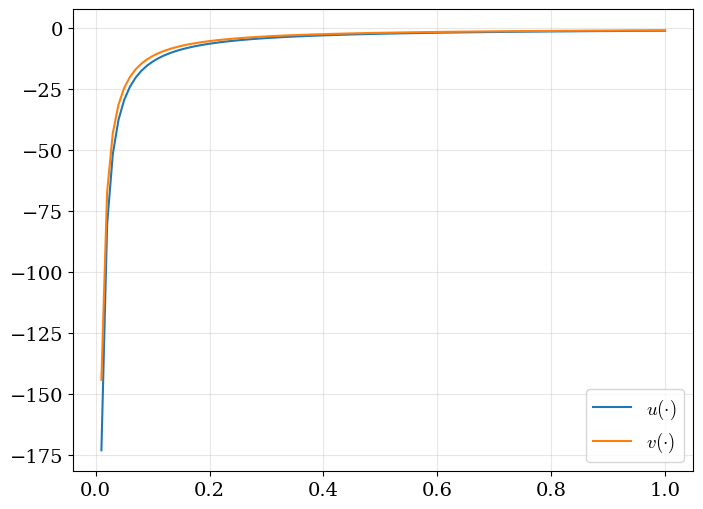

In [7]:
x = np.linspace(0.01, 1, 100)
y1 = U(x)
y2 = V(x)

plt.plot(x, y1, label=r"$u(\cdot)$")
plt.plot(x, y2, label=r"$v(\cdot)$")

plt.legend()
plt.show()

### No project

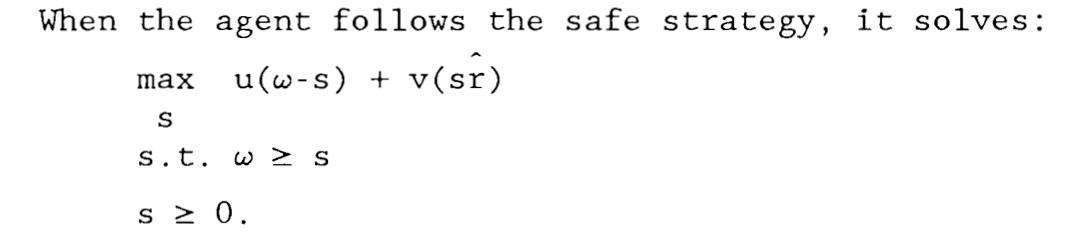

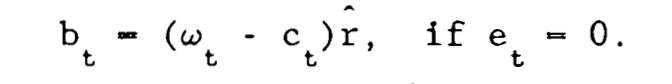

In [21]:
def bequest_safe(s):
    """
    Bequest when using safe strategy.
    """
    return s*r_hat

def consumption_utility(s, w):
    """
    Optimization function for safe investment strategy.
    We seek optimal s value.
    """
    return -(U(w-s) + V(s*r_hat))

def no_project_best_utility(w):
    """
    Finds optimal s for safe investment strategy.
    Args:
        w: wealth
    Returns:
        optimal utility, optimal s value
    """
    # optimization parameter is s, where 0 <= s <= w
    result = minimize(consumption_utility, args=(w), bounds=((0,w),), x0=w/2, method="Powell")
    return -result.fun, result.x[0]

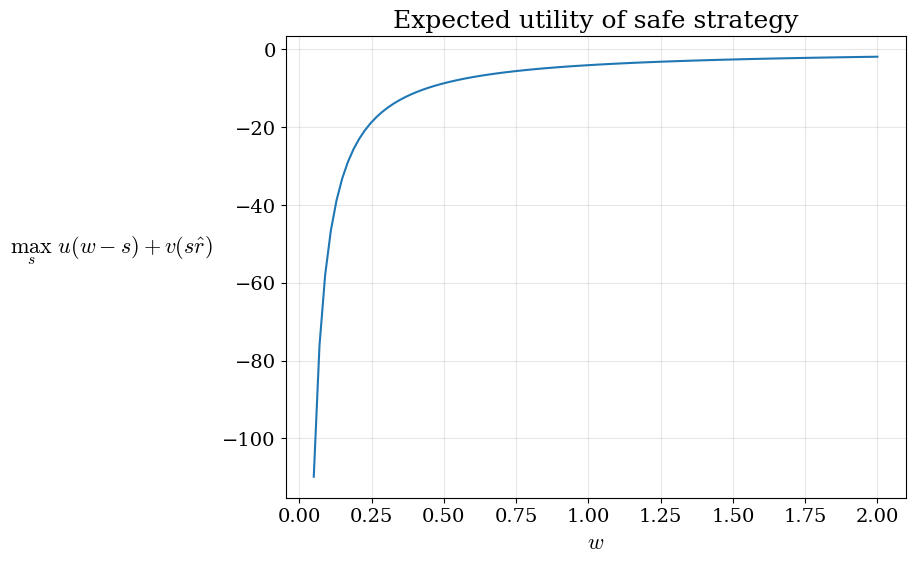

In [22]:
best_util = []
w_vals = np.linspace(0.05, 2, 100)
for w in w_vals:
    best_util.append(no_project_best_utility(w)[0])
plt.plot(w_vals, best_util)
plt.title("Expected utility of safe strategy")
plt.xlabel(r"$w$")
plt.ylabel(r"$\max_{s} \,\, u(w-s)+v(s\hat{r})$", rotation=0, labelpad=80)
plt.show()

# strictly increasing optimum as wealth increases
for i in range(1, len(best_util)):
    assert best_util[i] > best_util[i-1]

### Project

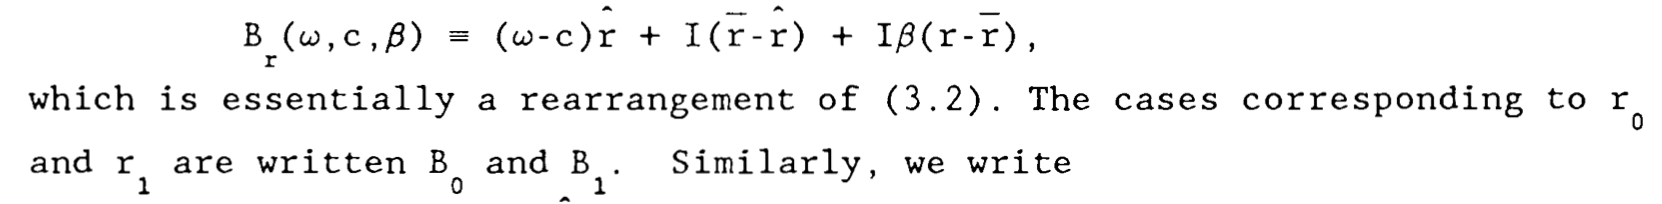

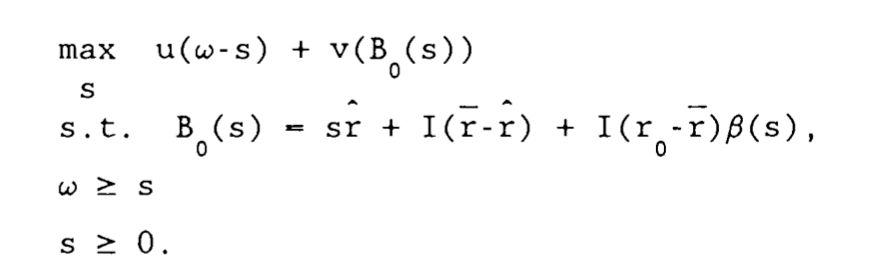

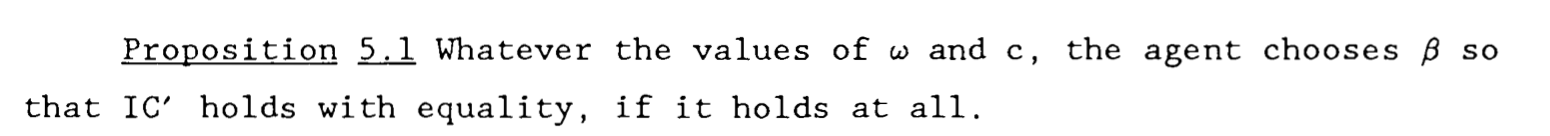

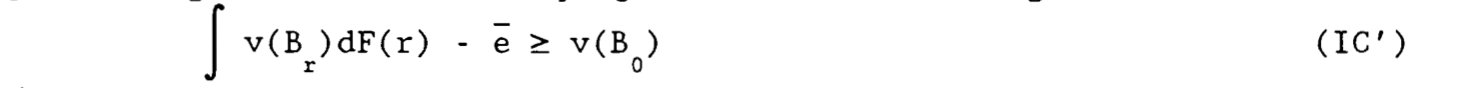

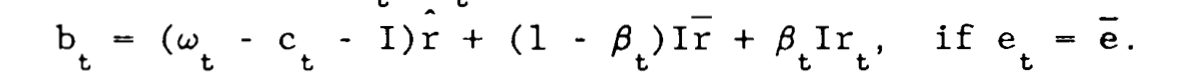

In [23]:
def bequest_project(s, beta, r):
    """
    Computes realized value of bequest for risky strategy with return r.
    Args:
        s    : amount saved
        beta : optimal beta
        r    : realized value of random variable for risky return
    Returns:
        the bequest amount
    """
    return s*r_hat + I*(r_bar-r_hat) + I*beta*(r-r_bar)


def optimal_beta_integral(beta, s):
    """
    See Proposition 5.1
    Args:
        beta : beta value
        s    : amount saved
    Returns:
        IC'
    """
    return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \
                                                   V(bequest_project(s,beta,r0)) - e_bar

def find_optimal_beta(s):
    """
    Function to find zero of optimal_beta_integral function, which corresponds to optimal beta.
    Args:
        s : amount saved
    Returns:
        optimal beta value; -1 if it does not exist
    """
    s = float(s)
    upper = 1.0
    while True:
        try:
            result = root_scalar(optimal_beta_integral, args=(s,), bracket=(0,upper)).root
            assert not isinstance(result, complex)
            return result
        except:
            upper -= 0.1
            if upper < 0:
                return -1
            else:
                continue


def project_optimization(s, w):
    """
    Optimization function for the risky investment strategy.
    Args:
        s: amount saved
        w: wealth
    Returns:
        utility
    """
    beta = find_optimal_beta(s)
    B0 = bequest_project(s, beta, r0)
    return -(U(w-s) + V(B0))


def project_best_utility(w):
    """
    Minimize project_optimization by finding optimal s.
    Args:
        w: wealth 
    Returns:
        optimal utility, optimal s, optimal beta
    """
    # optimization parameter is s
    result = minimize(project_optimization, args=(w,), bounds=((0,w),), method="L-BFGS-B", x0=w/2)
    s = result.x[0]
    utility = result.fun[0]
    return -utility, s, find_optimal_beta(s)

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


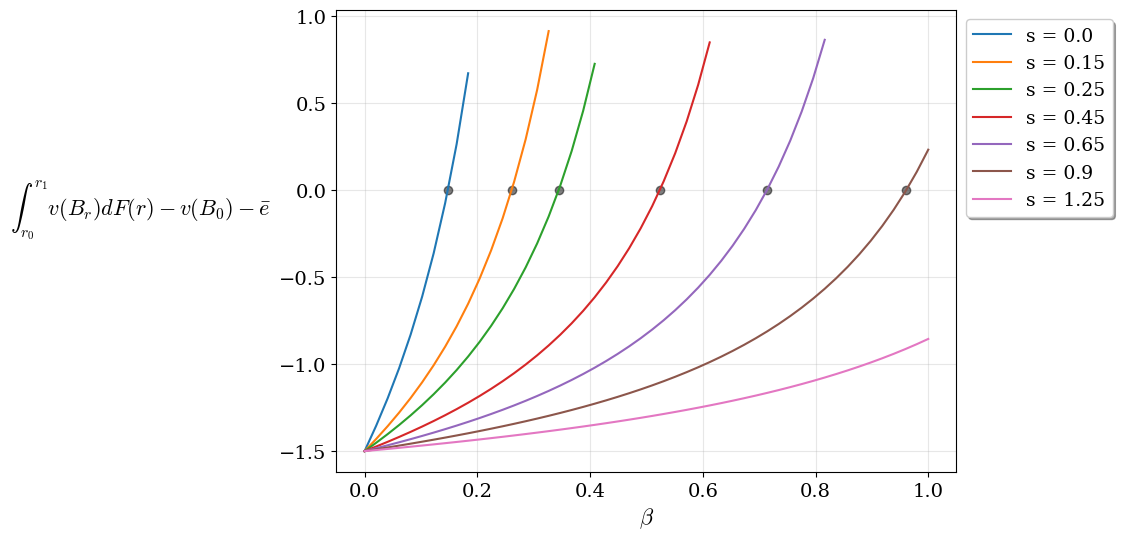

In [24]:
optimal_betas = []
w_vals = [0.0, 0.3, 0.5, 0.9, 1.3, 1.8, 2.5]
for w in w_vals:
    s = round(w-(w/2), 2)
    optimal_betas.append(find_optimal_beta(s))
    x = []
    vals = []
    beta_vals = np.linspace(0, 1, 50)
    for beta in beta_vals:
        value = optimal_beta_integral(beta, s)
        if not np.isnan(value) and value < 1:
            x.append(beta)
            vals.append(value)
        else:
            break

    # strictly increasing, as anticipated
    for i in range(1, len(vals)):
        assert vals[i] > vals[i-1]

    plt.plot(x, vals, label=f"s = {s}")

for o in optimal_betas:
    if o != -1:
        plt.scatter(o, 0, alpha=0.5, c='k', edgecolor="k")

plt.legend(shadow=True, bbox_to_anchor=(1,1))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\int_{r_0}^{r_1}v(B_r)dF(r) - v(B_0) - \bar{e}$", rotation=0, labelpad=100)
plt.show()

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


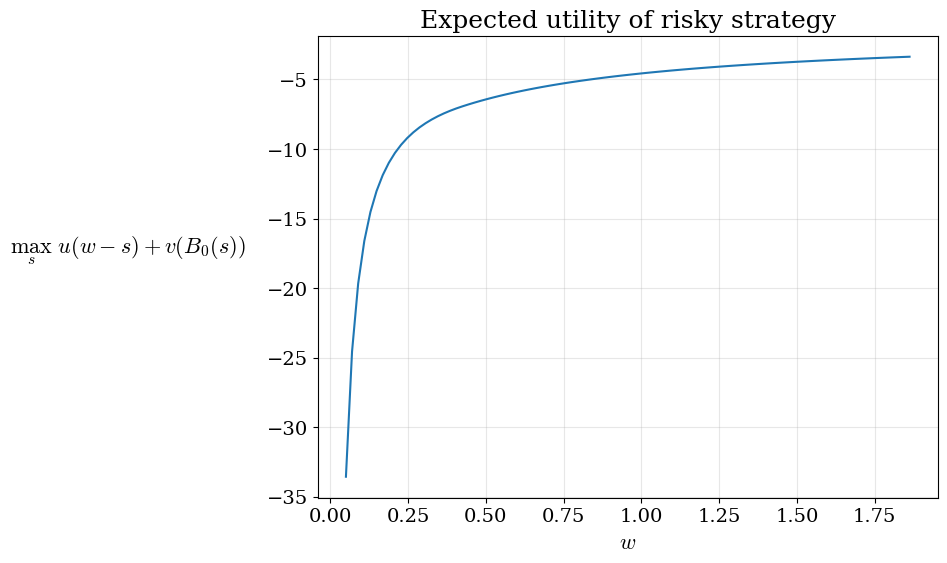

In [25]:
best_util = []
w_vals = np.linspace(0.05, 2, 100)
x = []

for w in w_vals:
    u, s, beta = project_best_utility(w)
    if beta != -1:
        best_util.append(u)
        x.append(w)
    else:
        break
        
plt.plot(x, best_util)
plt.title("Expected utility of risky strategy")
plt.xlabel(r"$w$")
plt.ylabel(r"$\max_{s} \,\, u(w-s)+v(B_0(s))$", rotation=0, labelpad=100)
plt.show()

# strictly increasing optimum as wealth increases
for i in range(1, len(best_util)):
    assert best_util[i] > best_util[i-1]

## Simulations

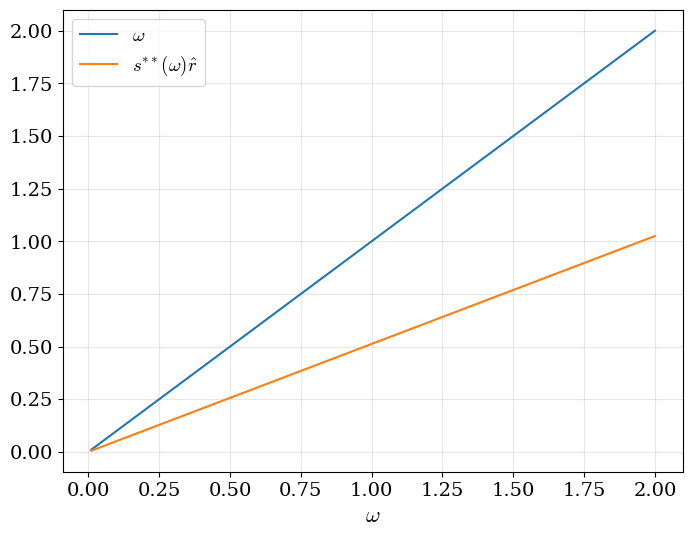

In [26]:
# Proposition 5.5 : for all positive wealth, s**(w).r_hat < w
y1 = []
y2 = []

w_vals = np.linspace(0.01, 2, 500)
for w in w_vals:
    y1.append(w)
    u, s = no_project_best_utility(w)
    assert s*r_hat < w
    y2.append(s * r_hat)
    
plt.plot(w_vals, y1, label=r"$\omega$")
plt.plot(w_vals, y2, label=r"$s^{**}(\omega)\hat{r}$")
plt.xlabel(r"$\omega$")
plt.legend()
plt.show()

In [27]:
# Proposition 5.6 : At initial wealth \hat{B_0}, agent strictly prefers risky strategy
beta_hat = find_optimal_beta(s=0.0) # beta hat is equity share retained by agent who saves zero
B_0_hat = I*(r_bar-r_hat) + I*beta_hat*(r0-r_bar)

utility_project = project_best_utility(B_0_hat)[0]
utility_no_project = no_project_best_utility(B_0_hat)[0]

assert utility_project > utility_no_project

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


In [28]:
# Proposition 5.8 : For wealth < B_0_hat, bequest is always larger than initial wealth
for w in np.linspace(0.05, B_0_hat, 100):
    utility_project, s_project, beta = project_best_utility(w)
    assert bequest_project(s_project, beta, np.random.uniform(r0,r1)) > w

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


In [29]:
B_1_hat = I*(r_bar-r_hat) + I*beta_hat*(r1-r_bar)

In [30]:
print(B_0_hat, B_1_hat)

0.252365354382461 0.5476346456175388


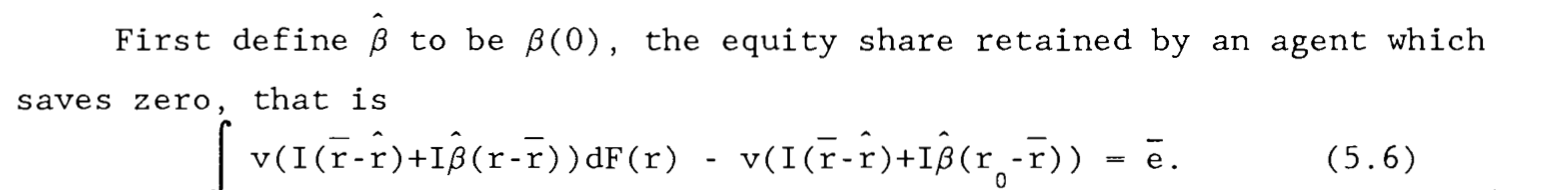

In [31]:
# output should equal e_bar
(1/(r1-r0)) * integrate.quad(lambda r: V(I*(r_bar-r_hat)+I*beta_hat*(r-r_bar)), r0, r1)[0] - \
                                       V(I*(r_bar-r_hat)+I*beta_hat*(r0-r_bar))

1.5000000000067137

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


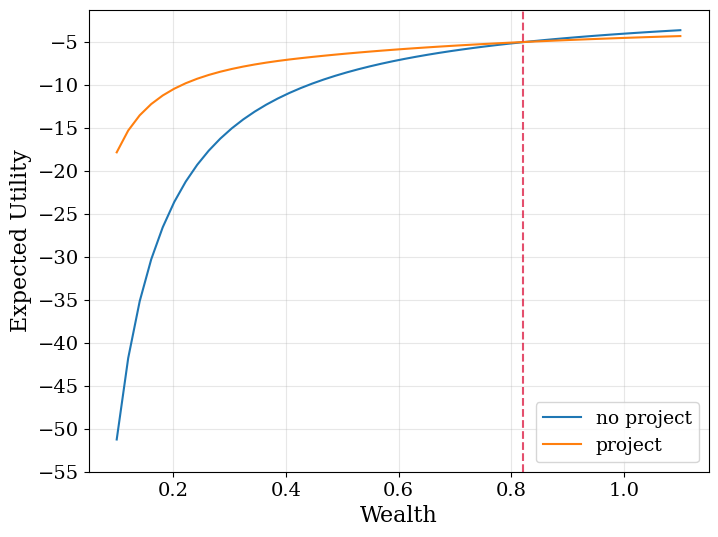

In [32]:
NP = []
P  = []

w_vals = np.linspace(0.1, 1.1, 50)

for wealth in w_vals:

    # project not undertaken
    utility_no_project = no_project_best_utility(wealth)[0]
    NP.append(utility_no_project)

    # project undertaken
    utility_project = project_best_utility(wealth)[0]
    P.append(utility_project)

plt.plot(w_vals, NP, label="no project")
plt.plot(w_vals, P, label="project")

plt.yticks(np.linspace(-55, -5, 11))
plt.xlabel("Wealth")
plt.ylabel("Expected Utility")

plt.axvline(x=0.82, linestyle="dashed", color="crimson", alpha=0.75)

plt.legend()
plt.show()

### Lineage wealth

In [33]:
reps        = 5000
random_vals = np.random.uniform(r0, r1, size=reps)

wealth = 0.1
lineage_wealth = [wealth]

for rep_idx, rep in enumerate(range(reps)):
    if (rep) % (reps / 10) == 0:
        print(rep/reps)

    # safe strategy
    utility_no_project, s_no_project = no_project_best_utility(wealth)

    # risky strategy
    utility_project, s_project, beta = project_best_utility(wealth)
    
    # choose project
    if beta != -1 and utility_project > utility_no_project:
        # Proposition 5.4
        assert beta <= (r_bar-r_hat)/(r_bar-r0)
        
        # Proposition 5.5 : whenever project is chosen, s*(w).r_hat < w
        assert s_project*r_hat < wealth
        
        wealth = bequest_project(s_project, beta, random_vals[rep_idx])
    
    # choose safe strategy
    else:
        print(f"No project at w = {wealth}")
        c = wealth - s_no_project
        wealth = bequest_safe(s_no_project)
                
    lineage_wealth.append(wealth)

0.0


<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [34]:
for w in np.linspace(0.3, 0.45, 500):
    utility_project, s_project, beta = project_best_utility(w)
    if s_project > 0:
        w_hat = w
        print(w_hat)
        break

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


0.4217434869739479


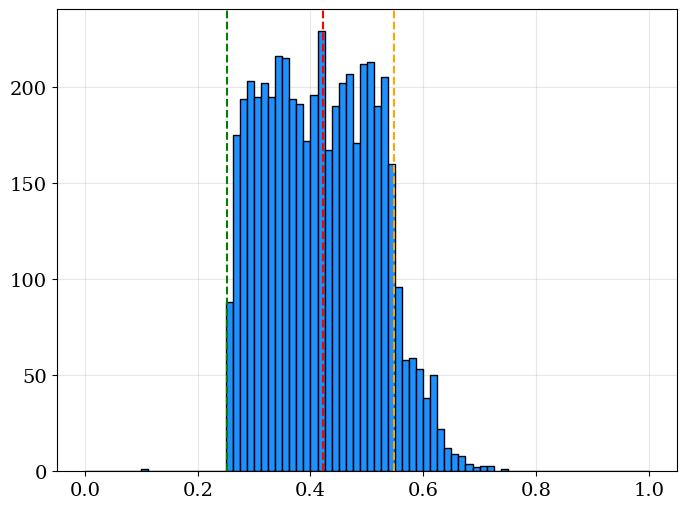

Mean lineage wealth = 0.419
Skew                = 0.208


In [35]:
plt.hist(lineage_wealth, bins=80, color="dodgerblue", edgecolor="k", range=[0, 1.0])

plt.axvline(B_0_hat, linestyle="dashed", color="green")
plt.axvline(w_hat, linestyle="dashed", color="red")
plt.axvline(B_1_hat, linestyle="dashed", color="orange")

plt.show()

print(f"Mean lineage wealth = {np.mean(lineage_wealth):.3f}")
print(f"Skew                = {skew(lineage_wealth):.3f}")

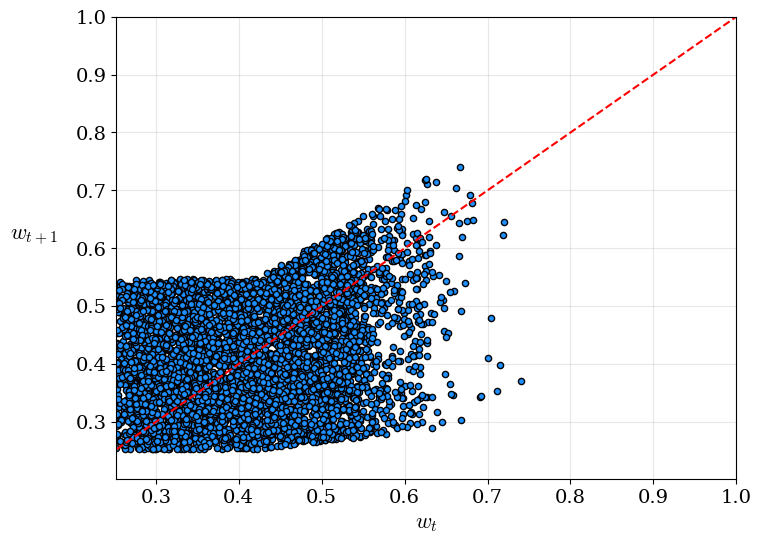

In [37]:
x = []
y = []
for i in range(len(lineage_wealth)-1):
    x.append(lineage_wealth[i])
    y.append(lineage_wealth[i+1])
plt.scatter(x, y, color="dodgerblue", s=20, edgecolor="k")

plt.xlabel(r"$w_t$")
plt.ylabel(r"$w_{t+1}$", rotation=0, labelpad=30)

plt.xlim(B_0_hat, 1)
plt.ylim(B_0_hat*0.8, 1)

plt.plot(np.linspace(0, 1, 1000), np.linspace(0,1,1000), color="red", linestyle="dashed")

plt.show()

<ipython-input-23-8cbdd45f1e4a>:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (1/(r1-r0)) * integrate.quad(lambda r : V(bequest_project(s,beta,r)), r0, r1)[0] - \


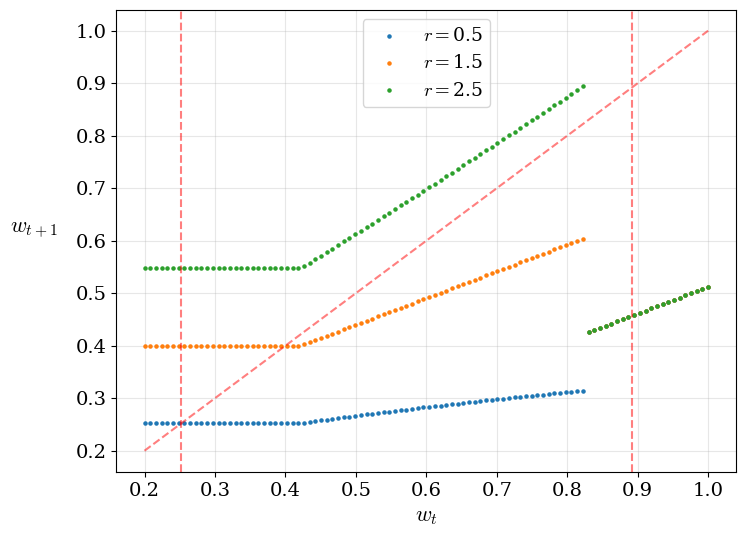

In [38]:
w_vals = np.linspace(0.2, 1, 100)
for r in [r0, r_bar, r1]:
    results = []
    for w in w_vals:
        utility_no_project, s_no_project = no_project_best_utility(w)
        utility_project, s, beta = project_best_utility(w)
        if utility_project > utility_no_project:
            results.append(bequest_project(s, beta, r))
        else:
            results.append(bequest_safe(s_no_project))
    plt.scatter(w_vals, results, label=r"$r=$" + f"{r}", s=5)
    
plt.plot(w_vals, w_vals, linestyle="dashed", color="red", alpha=0.5)
plt.axvline(B_0_hat, linestyle="dashed", color="red", alpha=0.5)

# plot B_1 (omega bar)
utility_project, s_project, beta = project_best_utility(0.82)
plt.axvline(bequest_project(s_project, beta, r1), linestyle="dashed", color="red", alpha=0.5)

plt.xlabel(r"$w_t$")
plt.ylabel(r"$w_{t+1}$", rotation=0, labelpad=30)
plt.legend()
plt.show()

### Wealth of multiple lineages

In [151]:
num_lineages = 7000
periods      = 6
random_vals  = np.random.uniform(r0, r1, size=periods*num_lineages)

w_init = 0.1
wealths = {k:w_init for k in range(num_lineages)}
random_idx = 0

for p in range(periods):
    print(p)
    
    for L in range(num_lineages):
        
        # safe strategy
        utility_no_project, s_no_project = no_project_best_utility(wealths[L])

        # risky strategy
        utility_project, s_project, beta = project_best_utility(wealths[L])

        if utility_project > utility_no_project:
            # Proposition 5.4
            assert beta <= (r_bar-r_hat)/(r_bar-r0)
            # Proposition 5.5 : whenever project is chosen, s*(w).r_hat < w
            assert s_project*r_hat < wealths[L]
            wealths[L] = bequest_project(s_project, beta, random_vals[random_idx])
            random_idx += 1
        else:
            print(f"No project at w = {wealths[L]}")
            wealths[L] = bequest_safe(s_no_project)

0


KeyboardInterrupt: 

In [ ]:
plt.hist(wealths.values(), bins=75, color="dodgerblue", edgecolor="k", range=[0, 0.9])
plt.axvline(B_1_hat, linestyle="dashed", color="red")
plt.show()

print(f"Mean wealth = {np.mean(list(wealths.values())):.3f}")
print(f"Skew        = {skew(lineage_wealth):.3f}")

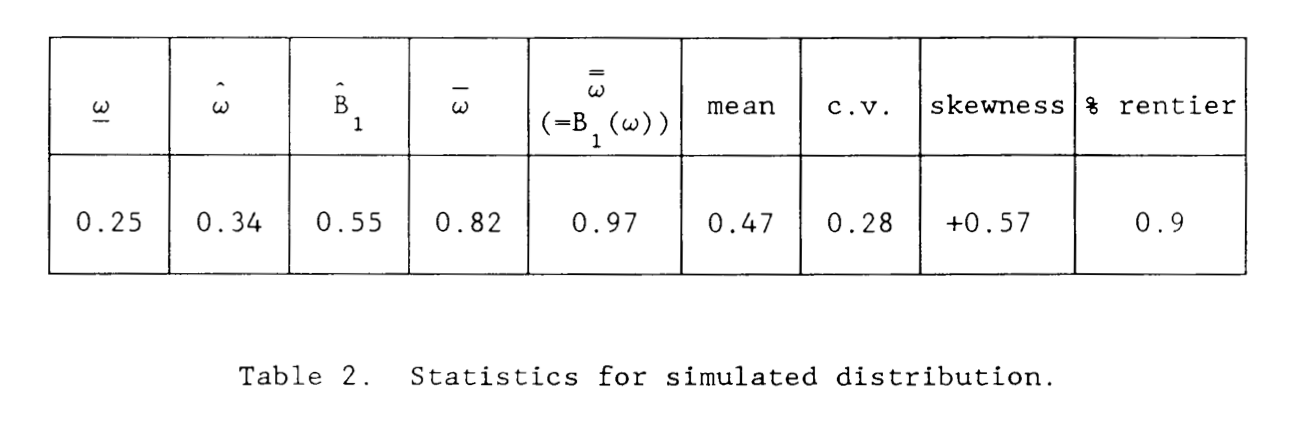

## PAWN Sensitivity Analysis Results

In [111]:
with open("results.pickle", "rb") as f:
    results = pickle.load(f)
    
keys = list(results.keys())
X = np.vstack(keys)

PROBLEM = {
    "num_vars" : 3,
    "names"    : ["I", "e_bar", "r1"],
    "bounds"   : [[0.8, 1.2],
                  [1.0, 1.7],
                  [2.0, 3.0]]
}

In [115]:
Y  = np.array([results[k]["mean"] for k in keys])
Si = pawn.analyze(PROBLEM, X, Y, S=10, print_to_console=True)

        minimum      mean    median   maximum        CV
I      0.098307  0.182990  0.160597  0.302284  0.387435
e_bar  0.106426  0.129552  0.129148  0.160578  0.134328
r1     0.369064  0.573564  0.570236  0.847656  0.253630


In [118]:
Y  = np.array([results[k]["mean"] for k in keys])
Si = pawn.analyze(PROBLEM, X, Y, S=50, print_to_console=True)

        minimum      mean    median   maximum        CV
I      0.121875  0.289183  0.284180  0.686719  0.356688
e_bar  0.133594  0.252952  0.232156  0.603516  0.331173
r1     0.361328  0.622010  0.606889  0.931641  0.246952
